Can an algorithm be developed with machine learning to predict how Google's stock prices will change?  To examine why it might be difficult or impossible to make such an algorithm, let's start by importing stock data from 2017 to 2022.  This will be our training data, and the ML algorithm's testing data will be on the stock performance since 2022.  

In [9]:
import yfinance as yf

ticker_symbol = "GOOG"

start_date = "2017-03-31"
end_date = "2022-03-31"

stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

print(stock_data.head())

print(stock_data.describe())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2017-03-31  41.448502  41.582001  41.369499  41.478001  41.478001  28038000
2017-04-03  41.460999  42.042500  41.460999  41.927502  41.927502  33430000
2017-04-04  41.568001  41.758999  41.451801  41.728500  41.728500  20908000
2017-04-05  41.775501  42.122501  41.535999  41.570499  41.570499  31106000
2017-04-06  41.619999  41.819500  41.323002  41.394001  41.394001  25088000
              Open         High          Low        Close    Adj Close  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean     76.742234    77.521468    76.000819    76.786516    76.786516   
std      31.874024    32.167696    31.549978    31.856085    31.856085   
min      41.096500    41.319000    40.851002    41.167500    41.167500   
25%      54.111750    54.708374    53.489250    54.122000    54.122000   
50%      61.400501    62

Now let's look to see if there are any gaps in the data - missing values or ourliers that might indicate that the data is faulty.  

Missing Values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Outliers:
{'Open': 83, 'High': 81, 'Low': 82, 'Close': 85, 'Adj Close': 85, 'Volume': 71}


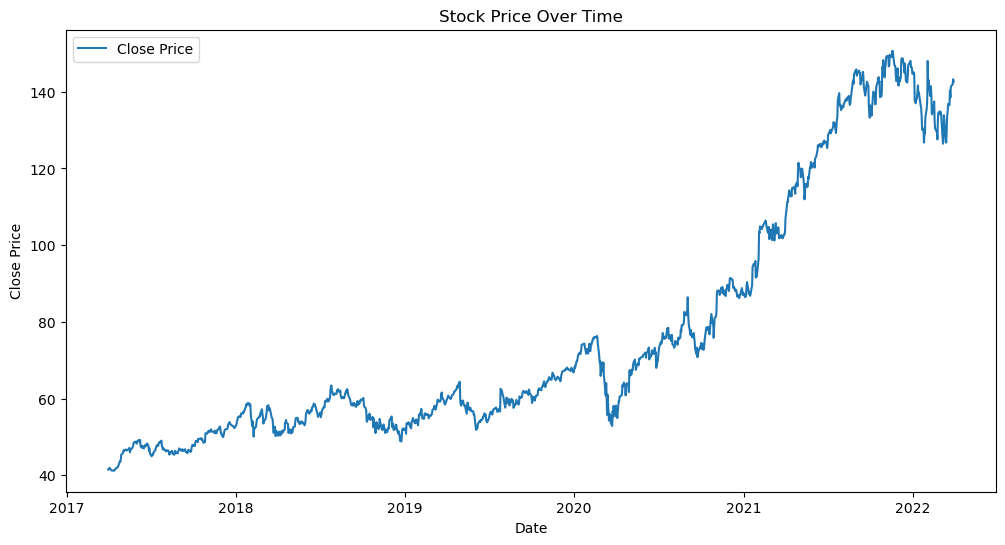

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

missing_values = stock_data.isnull().sum()
print("Missing Values:")
print(missing_values)

outliers = {}
for column in stock_data.columns:
    if np.issubdtype(stock_data[column].dtype, np.number):
        q1 = stock_data[column].quantile(0.25)
        q3 = stock_data[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers[column] = stock_data[(stock_data[column] < lower_bound) | (stock_data[column] > upper_bound)].shape[0]

print("\nOutliers:")
print(outliers)

plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Close Price')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

Good - the data seems to have no missing values or faulty outliers.  Now let's use statistical measures like mean, median, mode, and standard deviation to understand how the data is spread.`

In [14]:
summary_stats = stock_data.describe()

mean_values = summary_stats.loc['mean']
median_values = stock_data.median()
std_values = summary_stats.loc['std']
min_values = summary_stats.loc['min']
max_values = summary_stats.loc['max']

summary_df = pd.DataFrame({
    'Mean': mean_values,
    'Median': median_values,
    'Standard Deviation': std_values,
    'Minimum': min_values,
    'Maximum': max_values
})

print("Summary Statistics for Stock Data:")
print(summary_df.to_string(float_format="{:.3f}".format))

Summary Statistics for Stock Data:
                  Mean       Median  Standard Deviation     Minimum       Maximum
Open            76.742       61.401              31.874      41.097       151.863
High            77.521       62.028              32.168      41.319       152.100
Low             76.001       60.826              31.550      40.851       149.887
Close           76.787       61.458              31.856      41.167       150.709
Adj Close       76.787       61.458              31.856      41.167       150.709
Volume    31259702.939 27792000.000        13857717.021 6936000.000 124140000.000


The standard deviation of roughly 32 for the stock values is rather high - suggesting a wide distribution of prices over those years.  And the difference between the minimums (roughly 41) and the maximums(roughly 151) are significant.  The graph above shows the trajectory of how the stock's value has grown over time, which helps to account for the large difference between the highest and lowest values. It is also impressive how much volume of trading the stock regularly experiences, with a maximum of 124,140,000, which is enormous.  

Now let's perform a linear regression to find a line of best fit, which might model how the data changes over time.  A good linear regression could help to predict how the stock may change in the future, since it can be projected forward.  

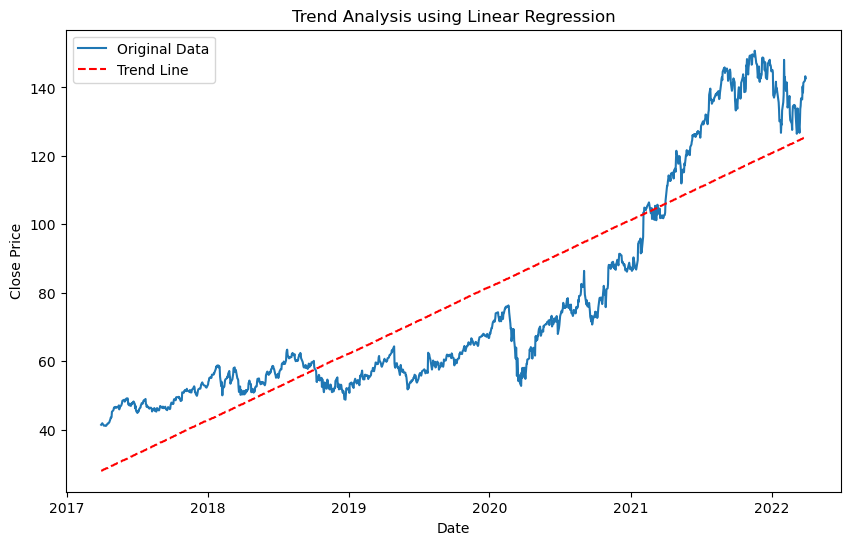

Mean Absolute Error (MAE): 13.121226066506267
Mean Squared Error (MSE): 221.43501493705506
Root Mean Squared Error (RMSE): 14.880692690095279
R-squared (R2): 0.7816231556962013


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

close_prices = stock_data['Close']

time_index = np.arange(len(close_prices)).reshape(-1, 1)

model = LinearRegression()
model.fit(time_index, close_prices.values.reshape(-1, 1))

trend_values = model.predict(time_index)

plt.figure(figsize=(10, 6))
plt.plot(stock_data.index, close_prices, label='Original Data')
plt.plot(stock_data.index, trend_values, color='red', linestyle='--', label='Trend Line')
plt.title('Trend Analysis using Linear Regression')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


predicted_values = model.predict(time_index)

mae = mean_absolute_error(close_prices, predicted_values)
mse = mean_squared_error(close_prices, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(close_prices, predicted_values)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

This linear regression is okay - after all, the R-squared measure suggests that about 78% of the stock's value can be explained by the line of best fit.
Nevertheless, I think that we could find a better statistical measure to quantify the data.  Let's try a polynomial regression, using a quadratic equation to model to stock's performance. 

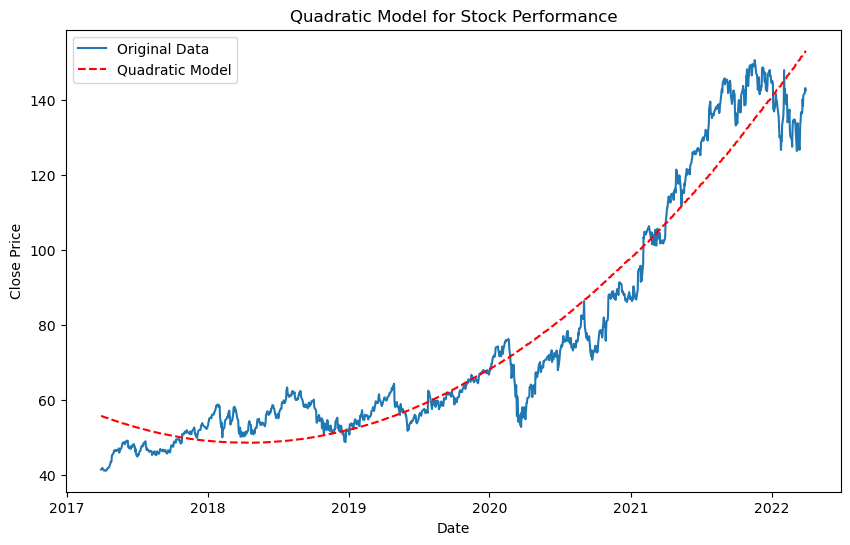

Quadratic Equation:
Close = 55.76 + -0.05 * t + 0.00 * t^2
Mean Absolute Error (MAE): 6.631590832892388
Mean Squared Error (MSE): 67.25336112972276
Root Mean Squared Error (RMSE): 8.200814662563882
R-squared (R2): 0.9336754542794083


In [31]:
from sklearn.preprocessing import PolynomialFeatures

close_prices = stock_data['Close']

time_index = np.arange(len(close_prices)).reshape(-1, 1)

poly_features = PolynomialFeatures(degree=2)
time_index_poly = poly_features.fit_transform(time_index)

model = LinearRegression()
model.fit(time_index_poly, close_prices)

predicted_close_prices = model.predict(time_index_poly)

mae = mean_absolute_error(close_prices, predicted_close_prices)
mse = mean_squared_error(close_prices, predicted_close_prices)
rmse = np.sqrt(mse)
r2 = r2_score(close_prices, predicted_close_prices)

plt.figure(figsize=(10, 6))
plt.plot(stock_data.index, close_prices, label='Original Data')
plt.plot(stock_data.index, predicted_close_prices, color='red', linestyle='--', label='Quadratic Model')
plt.title('Quadratic Model for Stock Performance')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

coefficients = model.coef_
intercept = model.intercept_

formula = f"Close = {intercept:.2f} + {coefficients[1]:.2f} * t + {coefficients[2]:.2f} * t^2"

print("Quadratic Equation:")
print(formula)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

This quadratic model is performing much better than the linear one, but is not yet accounting for the peaks an valleys found in the stock's price.  Let's try to find cycles in how the price rises and falls, using a seasonal decomposition.  This will generate two parts: seasonal information, and residual variance.

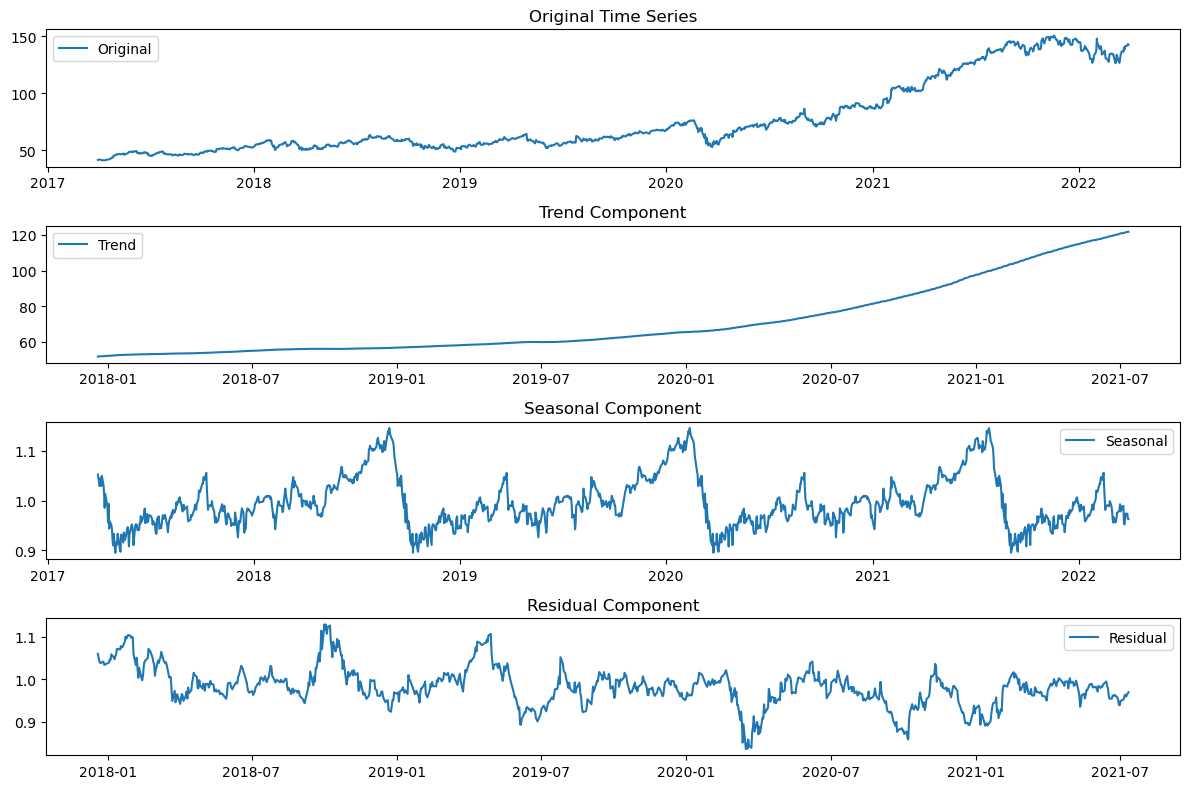

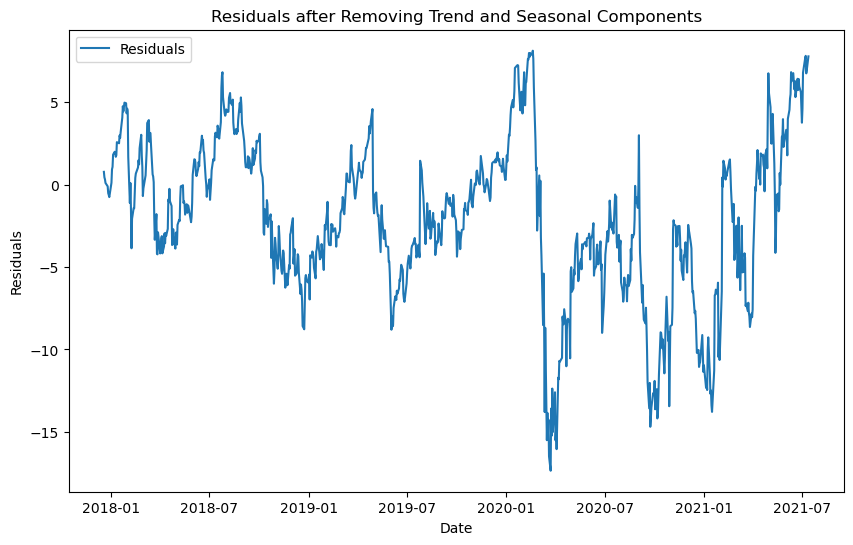

Standard Deviation of Residuals: 4.783722390498625


In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

close_prices = stock_data['Close']


result = seasonal_decompose(close_prices, model='multiplicative', period=365) 

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(close_prices, label='Original')
plt.title('Original Time Series')
plt.legend()

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.title('Trend Component')
plt.legend()

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()

trend_seasonal_removed = close_prices - result.trend - result.seasonal

plt.figure(figsize=(10, 6))
plt.plot(trend_seasonal_removed, label='Residuals')
plt.title('Residuals after Removing Trend and Seasonal Components')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

residual_std = trend_seasonal_removed.std()

print("Standard Deviation of Residuals:", residual_std)

I like the idea of accounting for seasonal variance, but I don't know if the current period of seasonal ups and downs quite match to the 365 period of one year.  Instead, I'll use a method called a periodogram to find the frequency of the peaks and valleys in the data.

Selected Frequencies: [0.00079428]
Selected Periods: [1259.]


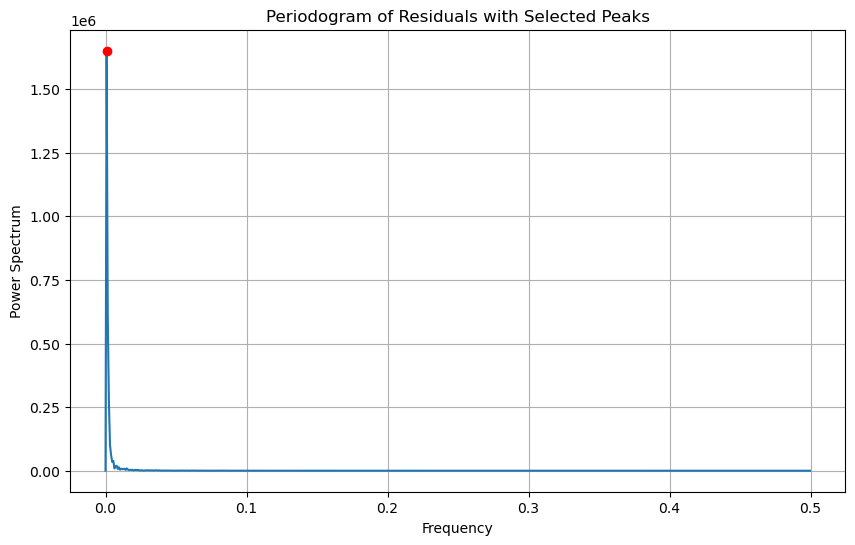

In [38]:
frequencies, power_spectrum = periodogram(residuals)

peaks, _ = find_peaks(power_spectrum, height=0.1, distance=10)  

selected_peaks = peaks[frequencies[peaks] < 1/365]

selected_frequencies = frequencies[selected_peaks]
selected_periods = 1 / selected_frequencies

print("Selected Frequencies:", selected_frequencies)
print("Selected Periods:", selected_periods)

plt.figure(figsize=(10, 6))
plt.plot(frequencies, power_spectrum)
plt.plot(frequencies[selected_peaks], power_spectrum[selected_peaks], 'ro')
plt.title('Periodogram of Residuals with Selected Peaks')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.grid(True)
plt.show()

This peridogram suggests that most of the variance happens so infrequently (on a scale of 1,259 days), that a seasonal decomposition may not be particularly helpful.  

Now let's try to make a machine learning algorithm, to perform better than these statistical measures.  Since I've already completed a linear analysis, let's try to use a higher dimensional model, through a Support Vector Regression (SVR), with Python's SciKitLearn library.

[*********************100%%**********************]  1 of 1 completed


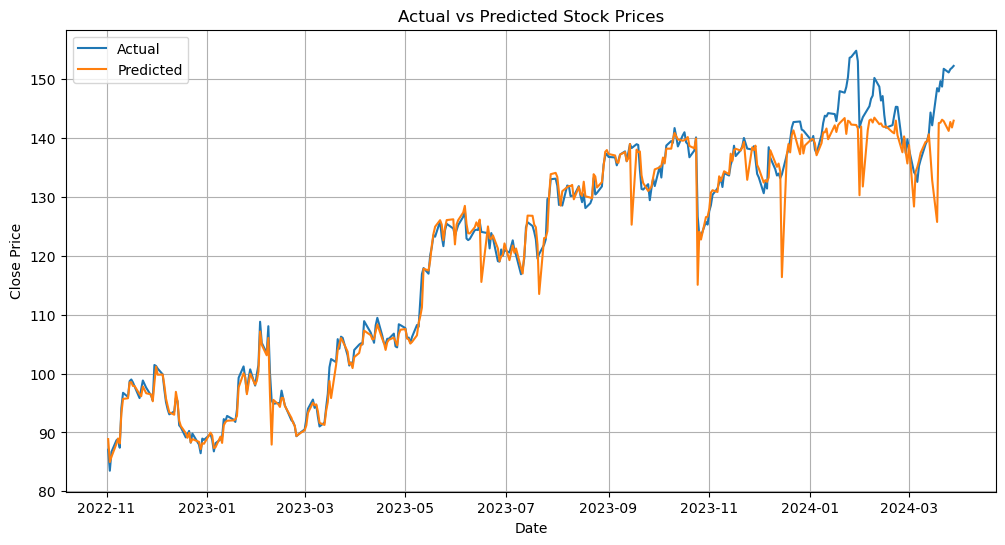

Support Vectors (SVs): (1219, 5)
Dual Coefficients: (1, 1219)
Intercept: [87.6691635]
Mean Squared Error (MSE): 10.946151090990128
Mean Absolute Error (MAE): 1.7884885801160386
R-squared (R2): 0.9712863665248942


In [42]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import yfinance as yf

goog_data = yf.download('GOOG', start='2017-03-31', end='2024-03-31')

X = goog_data.drop(columns=['Close'])  
y = goog_data['Close'] 

train_size = int(len(goog_data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = SVR(kernel='rbf')  
model.fit(X_train_scaled, y_train)

predictions = model.predict(X_test_scaled)

plt.figure(figsize=(12, 6))
plt.plot(goog_data.index[train_size:], y_test, label='Actual')
plt.plot(goog_data.index[train_size:], predictions, label='Predicted')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

support_vectors = model.support_vectors_
dual_coefficients = model.dual_coef_
intercept = model.intercept_


print("Support Vectors (SVs):", support_vectors.shape)
print("Dual Coefficients:", dual_coefficients.shape)
print("Intercept:", intercept)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

To remind myself, the quadratic model had the following values:
Mean Squared Error (MSE): 67.25336112972276
Mean Absolute Error (MAE): 6.631590832892388
R-squared (R2): 0.9336754542794083

So the SVR is performing much better than the quadratic function, and is doing so on new, previously 'unseen' testing data.  It does this by selecting 1,219 points (Support Vectors), which it uses to base its predictions upon.  

Let's compare this against another Machine Learning strategy - a Random Forest Regressor.  This is an 'ensemble' method, meaning that it makes multiple models and combines them together to make an aggregate that performs better than any of the constituent pieces.  Let's see how it performs on Google's stock data.

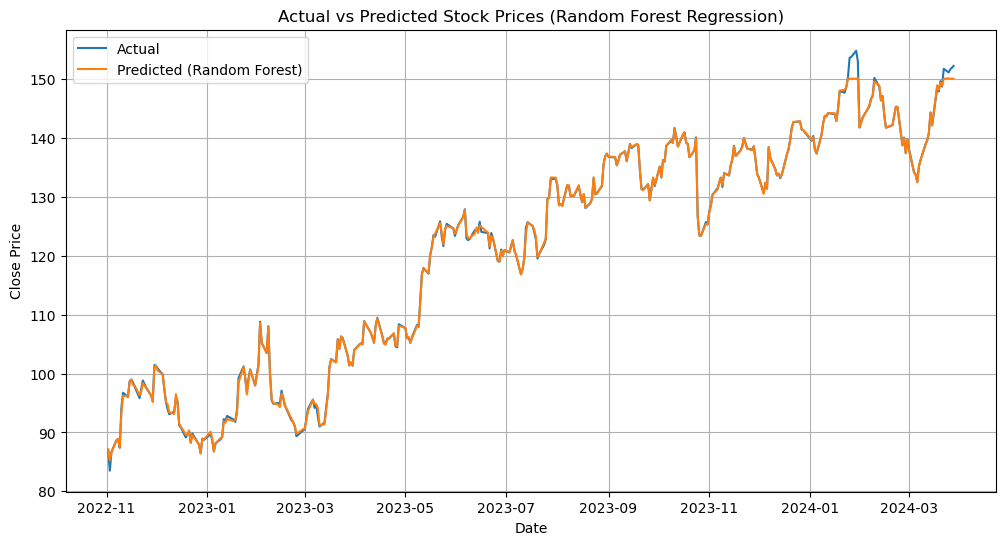

Mean Squared Error (MSE): 0.2699249345387019
Mean Absolute Error (MAE): 0.2206990402395072
R-squared (R2): 0.9992919405577623


In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import yfinance as yf

X = goog_data.drop(columns=['Close'])
y = goog_data['Close'] 

train_size = int(len(goog_data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = RandomForestRegressor(n_estimators=100, random_state=42) 
model.fit(X_train, y_train)

predictions = model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(goog_data.index[train_size:], y_test, label='Actual')
plt.plot(goog_data.index[train_size:], predictions, label='Predicted (Random Forest)')
plt.title('Actual vs Predicted Stock Prices (Random Forest Regression)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

This looks like a great model, however I am concerned that there may be overfitting - that it's ability to accurately account for existing data will blind it to future patterns.  I will try to use a learning curve to check if there's overfitting occuring.  Namely, I want to see the pattern of how more training data descreases the variance between the model and the actual data.

Cross-Validation Mean Squared Error: 2.107829746194611


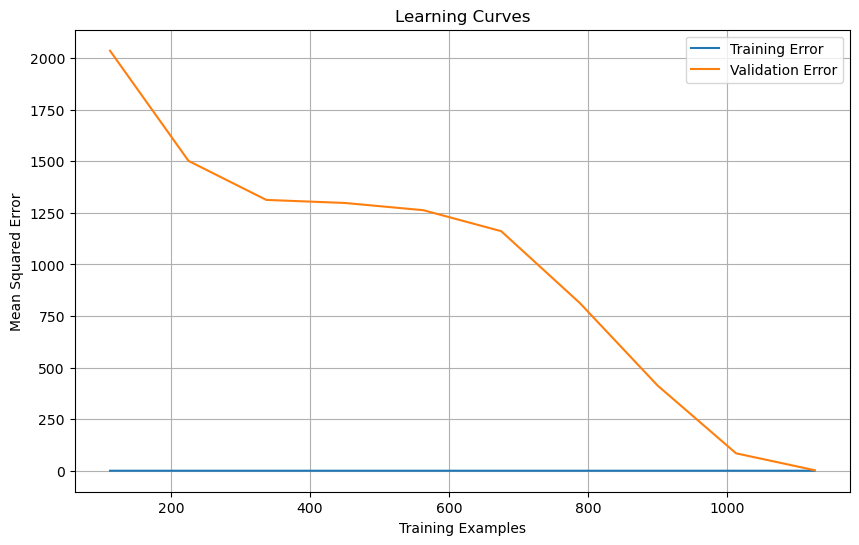

In [44]:
from sklearn.model_selection import cross_val_score, learning_curve

def plot_learning_curves(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, train_sizes=np.linspace(0.1, 1.0, 10),
                                                           scoring='neg_mean_squared_error', cv=5)
    train_scores_mean = -np.mean(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Error')
    plt.plot(train_sizes, val_scores_mean, label='Validation Error')
    plt.xlabel('Training Examples')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

cv_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
print("Cross-Validation Mean Squared Error:", -np.mean(cv_scores))

plot_learning_curves(model, X_train, y_train)

I learned several things from this project.  Most significantly, modern machine learning algorithms like Support Vector Regression and Random Forest Regression are far more powerful and accurate than basic linear or logistic regression.  Also, while periodization may be a good idea for tracking the cyclical ups and downs of a stock, it may not be applicable in cases where the stock takes a significant rise, as is the case with Google.  Overall, I am interested in digging deeper into the differences between class of ML algorithms, and identifying when overfitting is occuring - a problem which may be inevitable when it comes to predicting stock performance.